In [1]:
# USAGE
# python train.py --dataset dataset

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

d:\users\agautam\anaconda3\envs\ml\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\users\agautam\anaconda3\envs\ml\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\users\agautam\anaconda3\envs\ml\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\users\agautam\anaconda3\envs\ml\lib\site-packages\tensorflow\python\frame

In [1]:
args={'dataset':'dataset',
     'plot':"plot.png",
     'model':"covid19.model"}

In [2]:
args

{'dataset': 'dataset', 'plot': 'plot.png', 'model': 'covid19.model'}

In [3]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

[INFO] loading images...


NameError: name 'paths' is not defined

## VGG16 Model architecture modified to output only two outputs and accept images in the shape of (244,244,3)

In [4]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Freezing layers of base VGG16 model

In [5]:
#Tenporary
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

In [6]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [77]:
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/25
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
158/158 [==============================] - 249s 2s/step - loss: 0.1845 - acc: 0.9301 - val_loss: 0.1186 - val_acc: 0.9527
Epoch 2/25
158/158 [==============================] - 276s 2s/step - loss: 0.1222 - acc: 0.9619 - val_loss: 0.1082 - val_acc: 0.9590
Epoch 3/25
158/158 [==============================] - 277s 2s/step - loss: 0.1002 - acc: 0.9698 - val_loss: 0.0937 - val_acc: 0.9685
Epoch 4/25
158/158 [==============================] - 301s 2s/step - loss: 0.0870 - acc: 0.9746 - val_loss: 0.0768 - val_acc: 0.9716
Epoch 5/25
158/158 [==============================] - 320s 2s/step - loss: 0.0823 - acc: 0.9738 - val_loss: 0.0723 - val_acc: 0.9779
Epoch 6/25
158/158 [==============================] - 304s 2s/step - loss: 0.0760 - acc: 0.9730 - val_loss: 0.0631 - val_acc: 0.9748
Epoch 7/25
158/158 [==============================] - 326s 2s/step - loss: 0.0722 - 

In [78]:
model.save_weights('model_2.hd5')

In [80]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model/model_2.h5")
print("Saved model to disk")

Saved model to disk


In [9]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.72      0.98      0.83        47
      normal       1.00      0.93      0.96       270

    accuracy                           0.94       317
   macro avg       0.86      0.96      0.90       317
weighted avg       0.95      0.94      0.94       317



In [10]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[ 46   1]
 [ 18 252]]
acc: 0.9401
sensitivity: 0.9787
specificity: 0.9333


[[ 46   1]
 [  0 270]]
acc: 0.9968
sensitivity: 0.9787
specificity: 1.0000
[INFO] saving COVID-19 detector model...


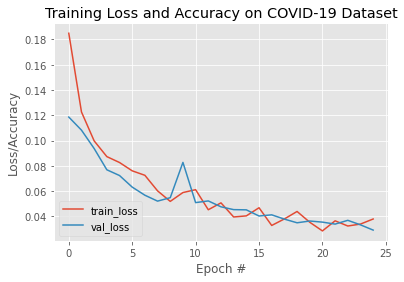

In [83]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
model.save(args["model"], save_format="h5")